In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['simhei']
sns.set_style({'font.sans-serif':['simhei']})
%matplotlib inline

## 1.数据概览

In [31]:
df = pd.read_excel('./data/trade_data.xlsx')
df.head()

,品牌名称,买家昵称,付款日期,订单状态,实付金额,邮费,省份,城市,购买数量
0,品牌A,叫我李2,2019-01-01 00:17:59,交易成功,186,6,上海,上海市,1
1,品牌A,0cyb1992,2019-01-01 00:59:54,交易成功,145,0,广东省,广州市,1
2,品牌A,萝污萌莉,2019-01-01 07:48:48,交易成功,194,8,山东省,东营市,1
3,品牌A,atblovemyy,2019-01-01 09:15:49,付款以后用户退款成功，交易自动关闭,84,0,江苏省,镇江市,1
4,品牌A,小星期鱼,2019-01-01 09:59:33,付款以后用户退款成功，交易自动关闭,74,0,上海,上海市,1


#### 查看交易状态

In [32]:
df['订单状态'].unique()

array(['交易成功', '付款以后用户退款成功，交易自动关闭'], dtype=object)

In [33]:
df['省份'].unique()

array(['上海', '广东省', '山东省', '江苏省', '河北省', '辽宁省', '山西省', '浙江省', '河南省',
       '湖北省', '湖南省', '北京', '福建省', '四川省', '江西省', '广西壮族自治区', '黑龙江省', '贵州省',
       '安徽省', '天津', '陕西省', '云南省', '吉林省', '重庆', '海南省', '甘肃省', '内蒙古自治区',
       '新疆维吾尔自治区', '宁夏回族自治区', '青海省', '西藏自治区'], dtype=object)

In [34]:
# df['城市'].unique()

#### 查看数据类型

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28833 entries, 0 to 28832
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   品牌名称    28833 non-null  object        
 1   买家昵称    28833 non-null  object        
 2   付款日期    28833 non-null  datetime64[ns]
 3   订单状态    28833 non-null  object        
 4   实付金额    28833 non-null  int64         
 5   邮费      28833 non-null  int64         
 6   省份      28833 non-null  object        
 7   城市      28832 non-null  object        
 8   购买数量    28833 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(5)
memory usage: 2.0+ MB


## 2.数据清洗

#### 剔除退款

In [36]:
df = df.loc[df['订单状态'] == '交易成功',:]
print('剔除退款后还剩:%d行' % len(df))

剔除退款后还剩:27793行


#### 关键字段提取

In [37]:
df = df[['买家昵称','付款日期','实付金额']]
df.head()

,买家昵称,付款日期,实付金额
0,叫我李2,2019-01-01 00:17:59,186
1,0cyb1992,2019-01-01 00:59:54,145
2,萝污萌莉,2019-01-01 07:48:48,194
5,重碎叠,2019-01-01 10:00:07,197
6,iho_jann,2019-01-01 10:00:08,168


#### R值

In [38]:
r = df.groupby('买家昵称')['付款日期'].max().reset_index()
r.head()

,买家昵称,付款日期
0,.blue_ram,2019-02-04 17:49:34.000
1,.christiny,2019-01-29 14:17:15.000
2,.willn1,2019-01-11 03:46:18.000
3,.托托m,2019-01-11 02:26:33.000
4,0000妮,2019-06-28 16:53:26.458


In [39]:
r['R'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
r = r[['买家昵称','R']]
r.head()

,买家昵称,R
0,.blue_ram,146
1,.christiny,152
2,.willn1,170
3,.托托m,170
4,0000妮,2


#### F值

In [40]:
#添加日期标签列
df['日期标签'] = df['付款日期'].astype(str).str[:10]

#分组合并用户每天的订单
dup_f = df.groupby(['买家昵称','日期标签'])['付款日期'].count().reset_index()

#统计用户消费频次
f = dup_f.groupby('买家昵称')['付款日期'].count().reset_index()
f.columns = ['买家昵称','F']
f.head()

,买家昵称,F
0,.blue_ram,1
1,.christiny,1
2,.willn1,1
3,.托托m,1
4,0000妮,1


#### M值

In [41]:
sum_m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
sum_m.columns = ['买家昵称','总支付金额']
com_m = pd.merge(sum_m,f,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')

#计算用户平均消费金额
com_m['M'] = com_m['总支付金额'] / com_m['F']
com_m.head()

,买家昵称,总支付金额,F,M
0,.blue_ram,49,1,49.0
1,.christiny,183,1,183.0
2,.willn1,34,1,34.0
3,.托托m,37,1,37.0
4,0000妮,164,1,164.0


#### RFM

In [42]:
rfm = pd.merge(r,com_m,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')
rfm = rfm[['买家昵称','R','F','M']]
rfm.head()

,买家昵称,R,F,M
0,.blue_ram,146,1,49.0
1,.christiny,152,1,183.0
2,.willn1,170,1,34.0
3,.托托m,170,1,37.0
4,0000妮,2,1,164.0


## 3.分值计算

#### R值计算

In [43]:
rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE
0,.blue_ram,146,1,49.0,1.0
1,.christiny,152,1,183.0,1.0
2,.willn1,170,1,34.0,1.0
3,.托托m,170,1,37.0,1.0
4,0000妮,2,1,164.0,5.0


#### F、M值计算

In [44]:
rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE
0,.blue_ram,146,1,49.0,1.0,1.0,1.0
1,.christiny,152,1,183.0,1.0,1.0,4.0
2,.willn1,170,1,34.0,1.0,1.0,1.0
3,.托托m,170,1,37.0,1.0,1.0,1.0
4,0000妮,2,1,164.0,5.0,1.0,4.0


#### 和平均值对比，减少用户分类数量

In [45]:
rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1


## 4.用户价值分层

#### 构建合并指标

In [46]:
rfm['用户数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,用户数值
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101


#### 基于数值判断用户价值

In [47]:
def transform_label(x):
    if x == 111:
        label = '重要价值用户'
    elif x == 110:
        label = '消费潜力用户'
    elif x == 101:
        label = '频次深耕用户'
    elif x == 100:
        label = '新用户'
    elif x == 11:
        label = '重要价值流失预警用户'
    elif x == 10:
        label = '一般用户'
    elif x == 1:
        label = '高消费唤回用户'
    elif x == 0:
        label = '流失用户'
    return label

#### 添加用户价值标签列

In [48]:
rfm['用户类型'] = rfm['用户数值'].apply(transform_label)
rfm.head()

,买家昵称,R,F,M,R-SCORE,F-SCORE,M-SCORE,R是否大于均值,F是否大于均值,M是否大于均值,用户数值,用户类型
0,.blue_ram,146,1,49.0,1.0,1.0,1.0,0,0,0,0,流失用户
1,.christiny,152,1,183.0,1.0,1.0,4.0,0,0,1,1,高消费唤回用户
2,.willn1,170,1,34.0,1.0,1.0,1.0,0,0,0,0,流失用户
3,.托托m,170,1,37.0,1.0,1.0,1.0,0,0,0,0,流失用户
4,0000妮,2,1,164.0,5.0,1.0,4.0,1,0,1,101,频次深耕用户


#### 人数统计

In [49]:
count = rfm['用户类型'].value_counts().reset_index()
count.columns = ['用户类型','人数']
count['人数占比'] = count['人数'] / count['人数'].sum()
count

,用户类型,人数,人数占比
0,高消费唤回用户,7338,0.288670
1,流失用户,6680,0.262785
2,频次深耕用户,5427,0.213493
3,新用户,4224,0.166168
4,重要价值用户,756,0.029740
5,消费潜力用户,450,0.017703
6,重要价值流失预警用户,360,0.014162
7,一般用户,185,0.007278


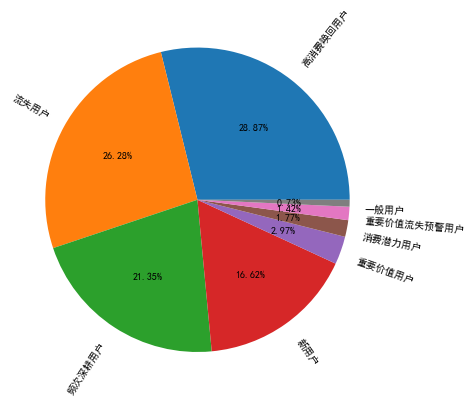

In [50]:
plt.figure(figsize=(7,7))
_ = plt.pie(count['人数'], labels=count['用户类型'],autopct='%0.2f%%',rotatelabels=True)

#### 消费金额统计

In [51]:
rfm['购买总金额'] = rfm['F'] * rfm['M']
mon = rfm.groupby('用户类型')['购买总金额'].sum().reset_index()
mon.columns = ['用户类型','消费金额']
mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()
mon

,用户类型,消费金额,金额占比
0,一般用户,25803.0,0.007349
1,新用户,270869.0,0.077142
2,流失用户,444617.0,0.126624
3,消费潜力用户,64075.0,0.018248
4,重要价值流失预警用户,116665.0,0.033226
5,重要价值用户,269230.0,0.076675
6,频次深耕用户,981893.0,0.279638
7,高消费唤回用户,1338153.0,0.381098


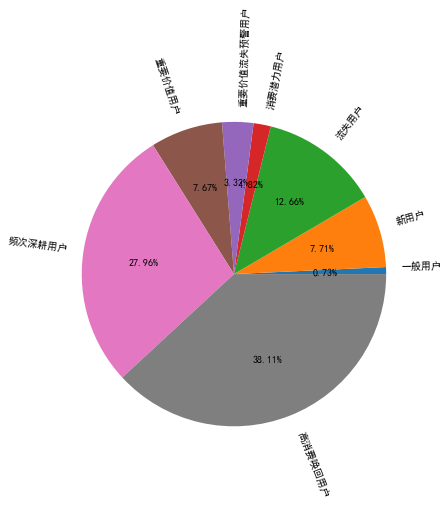

In [52]:
plt.figure(figsize=(7,7))
_ = plt.pie(mon['消费金额'], labels=mon['用户类型'],autopct='%0.2f%%',rotatelabels=True)

In [53]:
result = pd.merge(count,mon)
result

,用户类型,人数,人数占比,消费金额,金额占比
0,高消费唤回用户,7338,0.288670,1338153.0,0.381098
1,流失用户,6680,0.262785,444617.0,0.126624
2,频次深耕用户,5427,0.213493,981893.0,0.279638
3,新用户,4224,0.166168,270869.0,0.077142
4,重要价值用户,756,0.029740,269230.0,0.076675
5,消费潜力用户,450,0.017703,64075.0,0.018248
6,重要价值流失预警用户,360,0.014162,116665.0,0.033226
7,一般用户,185,0.007278,25803.0,0.007349


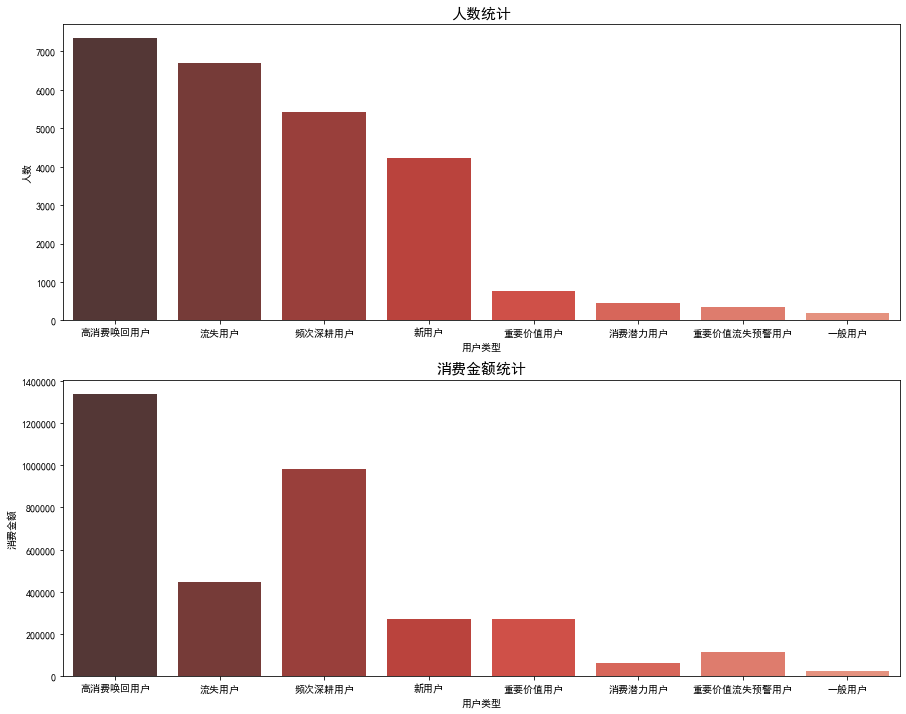

In [54]:
f, [ax1,ax2] = plt.subplots(2,1,figsize=(15,12))
sns.barplot(x=result['用户类型'], y=result['人数'], palette="Reds_d", data=result[['用户类型','人数']], ax=ax1)
ax1.set_title('人数统计',fontsize=15)
sns.barplot(x=result['用户类型'], y=result['消费金额'], palette="Reds_d", data=result[['用户类型','消费金额']], ax=ax2)
ax2.set_title('消费金额统计',fontsize=15)
plt.show()

## RFM模型封装

In [55]:
#输入源数据文件名
def get_rfm(name = './data/trade_data.xlsx'):
    """
    对用户价值的判断封装函数，基于RFM模型
    """
    df = pd.read_excel(name)
    df = df.loc[df['订单状态'] == '交易成功',:]
    print('剔除退款后还剩:%d行' % len(df))
    df = df[['买家昵称','付款日期','实付金额']]

    r = df.groupby('买家昵称')['付款日期'].max().reset_index()
    r['R'] = (pd.to_datetime('2019-7-1') - r['付款日期']).dt.days
    r = r[['买家昵称','R']]

    #添加日期标签列
    df['日期标签'] = df['付款日期'].astype(str).str[:10]

    #分组合并每个用户每天订单
    dup_f = df.groupby(['买家昵称','日期标签'])['付款日期'].count().reset_index()

    #统计用户消费频次
    f = dup_f.groupby('买家昵称')['付款日期'].count().reset_index()
    f.columns = ['买家昵称','F']

    sum_m = df.groupby('买家昵称')['实付金额'].sum().reset_index()
    sum_m.columns = ['买家昵称','总支付金额']
    com_m = pd.merge(sum_m,f,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')

    #计算用户平均消费金额
    com_m['M'] = com_m['总支付金额'] / com_m['F']

    rfm = pd.merge(r,com_m,left_on = '买家昵称',right_on = '买家昵称',how = 'inner')
    rfm = rfm[['买家昵称','R','F','M']]


    rfm['R-SCORE'] = pd.cut(rfm['R'],bins = [0,30,60,90,120,1000000],labels = [5,4,3,2,1],right = False).astype(float)
    rfm['F-SCORE'] = pd.cut(rfm['F'],bins = [1,2,3,4,5,1000000],labels = [1,2,3,4,5],right = False).astype(float)
    rfm['M-SCORE'] = pd.cut(rfm['M'],bins = [0,50,100,150,200,1000000],labels = [1,2,3,4,5],right = False).astype(float)

    rfm['R是否大于均值'] = (rfm['R-SCORE'] > rfm['R-SCORE'].mean()) * 1
    rfm['F是否大于均值'] = (rfm['F-SCORE'] > rfm['F-SCORE'].mean()) * 1
    rfm['M是否大于均值'] = (rfm['M-SCORE'] > rfm['M-SCORE'].mean()) * 1

    rfm['用户数值'] = (rfm['R是否大于均值'] * 100) + (rfm['F是否大于均值'] * 10) + (rfm['M是否大于均值'] * 1)

    rfm['用户类型'] = rfm['用户数值'].apply(transform_label)

    count = rfm['用户类型'].value_counts().reset_index()
    count.columns = ['用户类型','人数']
    count['人数占比'] = count['人数'] / count['人数'].sum()

    rfm['购买总金额'] = rfm['F'] * rfm['M']
    mon = rfm.groupby('用户类型')['购买总金额'].sum().reset_index()
    mon.columns = ['用户类型','消费金额']
    mon['金额占比'] = mon['消费金额'] / mon['消费金额'].sum()

    result = pd.merge(count,mon)

    return result


def transform_label(x):
    """
    用户类型标签的映射函数，基于用户数值的映射
    """
    if x == 111:
        label = '重要价值用户'
    elif x == 110:
        label = '消费潜力用户'
    elif x == 101:
        label = '频次深耕用户'
    elif x == 100:
        label = '新用户'
    elif x == 11:
        label = '重要价值流失预警用户'
    elif x == 10:
        label = '一般用户'
    elif x == 1:
        label = '高消费唤回用户'
    elif x == 0:
        label = '流失用户'
    return label

In [56]:
res = get_rfm(name = './data/trade_data.xlsx')
res

剔除退款后还剩:27793行


,用户类型,人数,人数占比,消费金额,金额占比
0,高消费唤回用户,7338,0.288670,1338153.0,0.381098
1,流失用户,6680,0.262785,444617.0,0.126624
2,频次深耕用户,5427,0.213493,981893.0,0.279638
3,新用户,4224,0.166168,270869.0,0.077142
4,重要价值用户,756,0.029740,269230.0,0.076675
5,消费潜力用户,450,0.017703,64075.0,0.018248
6,重要价值流失预警用户,360,0.014162,116665.0,0.033226
7,一般用户,185,0.007278,25803.0,0.007349
